In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

from matplotlib import cm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import MiniBatchKMeans

%matplotlib inline


In [2]:
train_data = pd.read_pickle('train_data.pickle')

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415016 entries, 3 to 487464
Data columns (total 16 columns):
ID                  415016 non-null object
Start_Time          415016 non-null datetime64[ns]
End_Time            415016 non-null datetime64[ns]
Start_Latitude      415016 non-null float64
Start_Longitude     415016 non-null float64
End_Latitude        415016 non-null float64
End_Longitude       415016 non-null float64
Duration            415016 non-null float64
pick_month          415016 non-null int64
hour                415016 non-null int64
week_of_year        415016 non-null int64
day_of_year         415016 non-null int64
day_of_week         415016 non-null int64
hvsine_pick_drop    415016 non-null float64
manhtn_pick_drop    415016 non-null float64
bearing             415016 non-null float64
dtypes: datetime64[ns](2), float64(8), int64(5), object(1)
memory usage: 53.8+ MB


In [5]:
train_data.head()

,ID,Start_Time,End_Time,Start_Latitude,Start_Longitude,End_Latitude,End_Longitude,Duration,pick_month,hour,week_of_year,day_of_year,day_of_week,hvsine_pick_drop,manhtn_pick_drop,bearing
3,150814781,2016-07-01 06:07:01,2016-07-01 06:10:46,12.801986,77.704803,12.794087,77.721321,225.0,7,6,26,183,4,1.994858,2.669389,116.120964
4,150814781,2016-07-01 06:08:20,2016-07-01 06:11:30,12.801986,77.704803,12.792457,77.727730,190.0,7,6,26,183,4,2.702424,3.545570,113.081674
5,150814781,2016-07-01 06:10:49,2016-07-01 06:12:29,12.793974,77.721748,12.790604,77.732292,100.0,7,6,26,183,4,1.203180,1.518058,108.145288
6,150814781,2016-07-01 06:12:59,2016-07-01 06:17:27,12.788506,77.736084,12.781456,77.763435,268.0,7,6,26,183,4,3.067743,3.749774,104.802428
7,150814781,2016-07-01 06:15:58,2016-07-01 06:18:17,12.785234,77.751587,12.779743,77.767654,139.0,7,6,26,183,4,1.846180,2.352845,109.310795


In [6]:
l = ['pick_month','hour','week_of_year','day_of_year','day_of_week','hvsine_pick_drop','manhtn_pick_drop','bearing']

In [8]:
df = train_data.drop(l,axis=1)

In [9]:
df.head()

,ID,Start_Time,End_Time,Start_Latitude,Start_Longitude,End_Latitude,End_Longitude,Duration
3,150814781,2016-07-01 06:07:01,2016-07-01 06:10:46,12.801986,77.704803,12.794087,77.721321,225.0
4,150814781,2016-07-01 06:08:20,2016-07-01 06:11:30,12.801986,77.704803,12.792457,77.727730,190.0
5,150814781,2016-07-01 06:10:49,2016-07-01 06:12:29,12.793974,77.721748,12.790604,77.732292,100.0
6,150814781,2016-07-01 06:12:59,2016-07-01 06:17:27,12.788506,77.736084,12.781456,77.763435,268.0
7,150814781,2016-07-01 06:15:58,2016-07-01 06:18:17,12.785234,77.751587,12.779743,77.767654,139.0


In [24]:
coords = np.vstack((df[['Start_Latitude',  'Start_Longitude']].values,
                    df[['End_Latitude', 'End_Longitude']].values,
                    df[['Start_Latitude',  'Start_Longitude']].values,
                    df[['End_Latitude', 'End_Longitude']].values))
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords)

In [26]:
from haversine import haversine
def derive_features(df):
    df = df.copy()
    # Pickup-based features
    df['pickup_date'] = df['Start_Time'].dt.date
    df['pickup_weekday'] = df['Start_Time'].dt.weekday
    df['pickup_hour'] = df['Start_Time'].dt.hour
    df['pickup_month'] = df['Start_Time'].dt.month
    df['pickup_day'] = df['Start_Time'].dt.day
    # Brand new features
    df['haversine_distance'] = df.apply(lambda x: haversine((x['Start_Latitude'],  x['Start_Longitude']), 
                                                            (x['End_Latitude'], x['End_Longitude'])), axis=1)
    df['pickup_cluster']  = kmeans.predict(df[['Start_Latitude', 'Start_Longitude']])
    df['dropoff_cluster'] = kmeans.predict(df[['End_Latitude', 'End_Longitude']])
    return df



In [27]:
df = derive_features(df)

In [28]:
df.head()

,ID,Start_Time,End_Time,Start_Latitude,Start_Longitude,End_Latitude,End_Longitude,Duration,pickup_date,pickup_weekday,pickup_hour,pickup_month,pickup_day,haversine_distance,pickup_cluster,dropoff_cluster
3,150814781,2016-07-01 06:07:01,2016-07-01 06:10:46,12.801986,77.704803,12.794087,77.721321,225.0,2016-07-01,4,6,7,1,1.994861,21,21
4,150814781,2016-07-01 06:08:20,2016-07-01 06:11:30,12.801986,77.704803,12.792457,77.727730,190.0,2016-07-01,4,6,7,1,2.702428,21,21
5,150814781,2016-07-01 06:10:49,2016-07-01 06:12:29,12.793974,77.721748,12.790604,77.732292,100.0,2016-07-01,4,6,7,1,1.203182,21,21
6,150814781,2016-07-01 06:12:59,2016-07-01 06:17:27,12.788506,77.736084,12.781456,77.763435,268.0,2016-07-01,4,6,7,1,3.067747,21,12
7,150814781,2016-07-01 06:15:58,2016-07-01 06:18:17,12.785234,77.751587,12.779743,77.767654,139.0,2016-07-01,4,6,7,1,1.846182,12,12


In [29]:
print('Mean trip duration (min): {0:.2f}'.format(df['Duration'].mean()/60))
print('Max trip duration (min): {0:.2f}'.format(df['Duration'].max()/60))
print('Median trip duration (min): {0:.2f}'.format(df['Duration'].median()/60))

Mean trip duration (min): 26.51
Max trip duration (min): 495.72
Median trip duration (min): 20.58


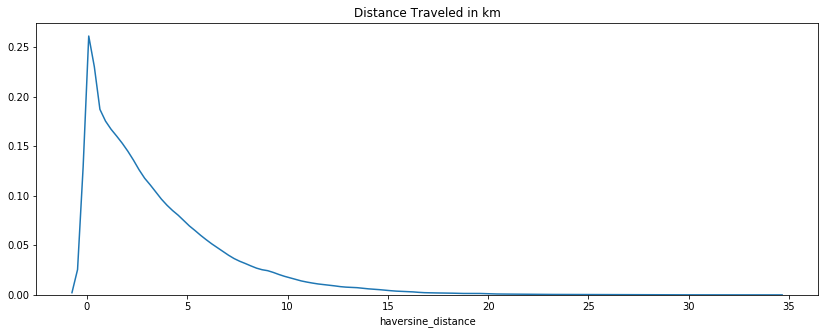

In [30]:
plt.figure(figsize=(14, 5))
plt.title('Distance Traveled in km')
sns.distplot(df['haversine_distance'], hist=False)

In [31]:
print('Mean trip distance (km): {0:.2f}'.format(df['haversine_distance'].mean()))
print('Max trip distance (km) {0:.2f}'.format(df['haversine_distance'].max()))
print('Median trip distance (km): {0:.2f}'.format(df['haversine_distance'].median()))

Mean trip distance (km): 3.57
Max trip distance (km) 33.91
Median trip distance (km): 2.50


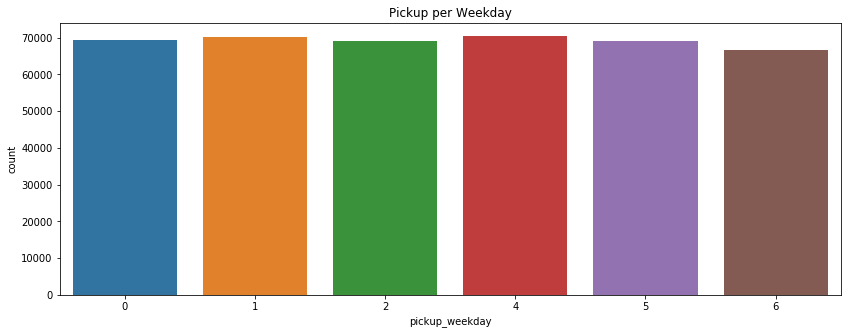

In [32]:
plt.figure(figsize=(14, 5))
plt.title('Pickup per Weekday')
sns.countplot(x='pickup_weekday', data=df)


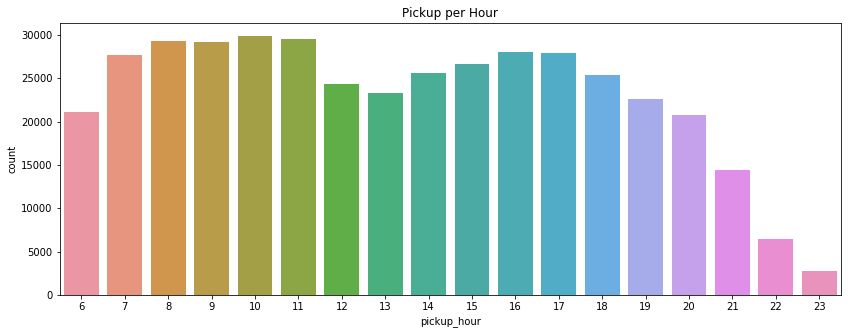

In [33]:
plt.figure(figsize=(14, 5))
plt.title('Pickup per Hour')
sns.countplot(x='pickup_hour', data=df)

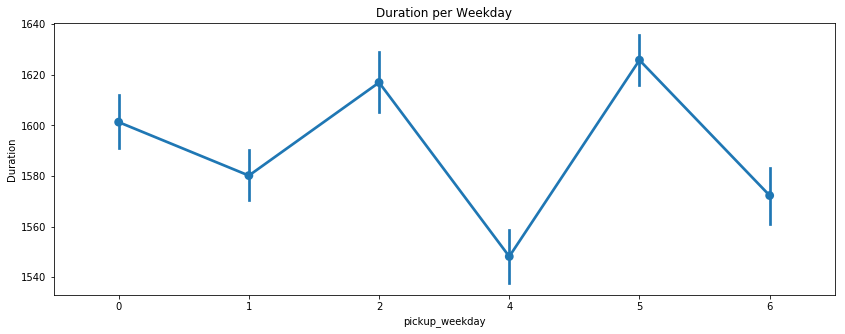

In [35]:
plt.figure(figsize=(14, 5))
plt.title('Duration per Weekday')
sns.pointplot(x='pickup_weekday', y='Duration', data=df)

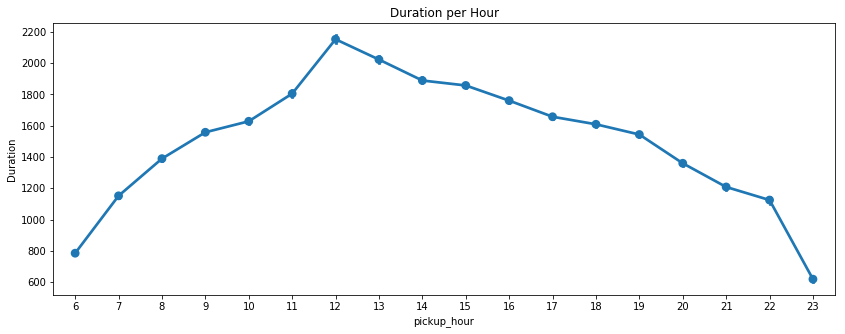

In [36]:
plt.figure(figsize=(14, 5))
plt.title('Duration per Hour')
sns.pointplot(x='pickup_hour', y='Duration', data=df)

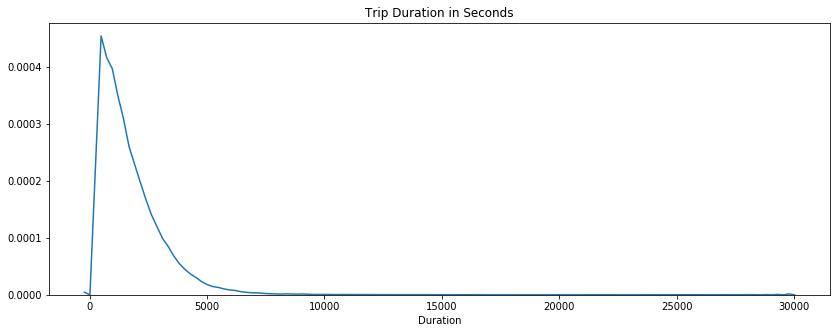

In [37]:
plt.figure(figsize=(14, 5))
plt.title('Trip Duration in Seconds')
sns.distplot(df['Duration'], hist=False)

In [38]:
print('Min trip distance (km): {0:.2f}'.format(df['haversine_distance'].min()))
print('Min trip duration (s): {0:.2f}'.format(df['Duration'].min()))

Min trip distance (km): 0.00
Min trip duration (s): 55.00


Text(0.5,1,'Correlation between features')

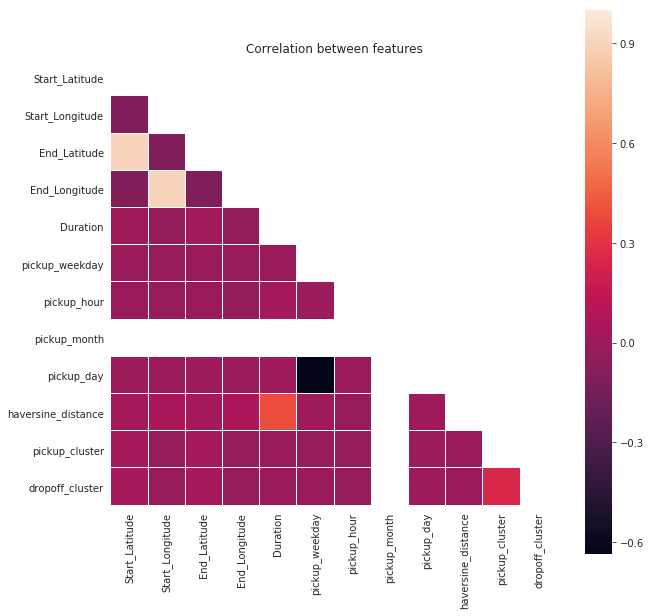

In [40]:
corr = df.select_dtypes(include=[np.number]).corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(10, 10))
with sns.axes_style('white'):
    sns.heatmap(corr, mask=mask, linewidths=0.01, square=True, linecolor='white')
plt.xticks(rotation=90)
plt.title('Correlation between features')

In [41]:
X = df.select_dtypes(include=[np.number])
X = X.drop(['Duration'], axis=1)
y = np.log1p(df['Duration'])

In [42]:
def rmsle_eval(y, y0):
    y0 = y0.get_label()    
    assert len(y) == len(y0)
    return 'error', np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y0), 2)))

In [44]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

params = {}
params["objective"] = "reg:linear"
params["eta"] = 0.1
params["min_child_weight"] = 30
params["subsample"] = 0.8
params["colsample_bytree"] = 0.3
params["scale_pos_weight"] = 1.0
params["silent"] = 1
params["max_depth"] = 10
params["nthread"] = -1

plst = list(params.items())

model = xgb.train(plst, dtrain, 1000, watchlist, early_stopping_rounds=50, maximize=False, 
                  verbose_eval=20, feval=rmsle_eval)

[0]	train-rmse:5.9095	valid-rmse:5.90584	train-error:1.31011	valid-error:1.30977
Multiple eval metrics have been passed: 'valid-error' will be used for early stopping.

Will train until valid-error hasn't improved in 50 rounds.
[20]	train-rmse:1.05208	valid-rmse:1.05224	train-error:0.133855	valid-error:0.133955
[40]	train-rmse:0.724938	valid-rmse:0.732154	train-error:0.096496	valid-error:0.097424
[60]	train-rmse:0.682669	valid-rmse:0.696343	train-error:0.091528	valid-error:0.093302
[80]	train-rmse:0.659484	valid-rmse:0.679707	train-error:0.088197	valid-error:0.090882
[100]	train-rmse:0.646777	valid-rmse:0.67133	train-error:0.086482	valid-error:0.089764
[120]	train-rmse:0.637216	valid-rmse:0.666067	train-error:0.085147	valid-error:0.089031
[140]	train-rmse:0.630766	valid-rmse:0.663035	train-error:0.084234	valid-error:0.088606
[160]	train-rmse:0.624363	valid-rmse:0.659139	train-error:0.083391	valid-error:0.088106
[180]	train-rmse:0.619212	valid-rmse:0.655842	train-error:0.082722	valid-er

In [46]:
test = pd.read_csv('test.csv')

In [47]:
test.head()

,Id,TimeStamp,LATLONG1,LATLONG2,LATLONG3,LATLONG4,LATLONG5,LATLONG6,LATLONG7,LATLONG8,...,LATLONG91,LATLONG92,LATLONG93,LATLONG94,LATLONG95,LATLONG96,LATLONG97,LATLONG98,LATLONG99,LATLONG100
0,150220445,2016-07-22 06:32:30,12.845321:77.66703000000003,12.845289999999999:77.666107,12.845347:77.665565,12.845364:77.66487099999998,12.845376:77.664261,12.84543:77.663361,12.845457000000001:77.662323,12.845512:77.661636,...,12.907288000000001:77.628647,12.908197:77.628113,12.909328:77.627449,12.910283999999999:77.6269,12.911159:77.626396,12.911705:77.625946,12.91203:77.625778,12.912778999999999:77.625366,12.913666000000001:77.624832,12.914212:77.624512
1,150811705,2016-07-31 05:22:33,12.965988000000001:77.535179,12.965983999999999:77.535217,12.965983999999999:77.535217,12.965983999999999:77.535217,12.965983999999999:77.535217,12.965983999999999:77.535217,12.965983999999999:77.535217,12.965983999999999:77.535217,...,12.965983999999999:77.535217,12.965983999999999:77.535217,12.965983999999999:77.535217,12.965983999999999:77.535217,12.965983999999999:77.535217,12.965983999999999:77.535217,12.965983999999999:77.535217,12.965983999999999:77.535217,12.965983999999999:77.535217,12.965983999999999:77.535217
2,150218073,2016-07-22 05:26:14,12.957028:77.559196,12.956954:77.559349,12.956980999999999:77.559494,12.957011999999999:77.559494,12.957021000000001:77.55947900000002,12.957024:77.55947900000002,12.957024:77.55947900000002,12.95702:77.55947900000002,...,12.927736999999999:77.551399,12.927241:77.551102,12.926368:77.550606,12.925618:77.550125,12.925413:77.55001800000002,12.925419:77.549812,12.925502:77.54960600000003,12.925761999999999:77.54908,12.926178:77.548477,12.926508:77.548103
3,150218420,2016-07-23 02:41:32,13.020817999999998:77.502739,13.020817999999998:77.502739,13.020817999999998:77.502739,13.020817999999998:77.502739,13.020817999999998:77.502739,13.020817999999998:77.502739,13.020817999999998:77.502739,13.020817999999998:77.502739,...,13.020817999999998:77.502739,13.020817999999998:77.502739,13.020817999999998:77.502739,13.020817999999998:77.502739,13.020817999999998:77.502739,13.020817999999998:77.502739,13.020817999999998:77.502739,13.020817999999998:77.502739,13.020817999999998:77.502739,13.020817999999998:77.502739
4,150219092,2016-07-22 18:58:04,12.982555:77.603226,12.982555:77.603226,12.982555:77.603226,12.982556:77.603226,12.982556:77.603226,12.982556:77.603226,12.982556:77.603226,12.982556:77.603226,...,12.98435:77.600571,12.984285:77.600075,12.984244:77.599525,12.984176:77.59906,12.984106:77.598648,12.98403:77.59819,12.983925:77.597755,12.983922999999999:77.597389,12.983922:77.597397,12.983919:77.597389


In [48]:
def plot_importances(clf):
    importances = clf.get_fscore()
    importances = sorted(importances.items(), key=lambda x: x[1])
    x = list(zip(*importances))[0]
    y = list(zip(*importances))[1]
    x_pos = np.arange(len(x)) 
    plt.figure(figsize=(10,5))
    plt.title('Feature importances')
    plt.barh(range(len(y)), y, align='center')
    plt.yticks(range(len(y)), x)
    plt.ylim([-1, len(importances)])
    plt.xlabel('F score')
    plt.show()

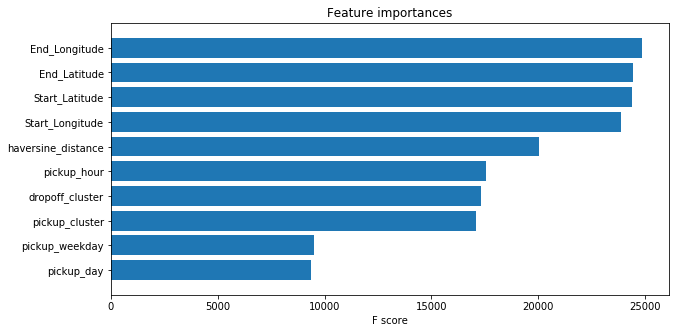

In [49]:
plot_importances(model)

In [50]:
model1 = xgb.train(plst, dtrain, 20000, watchlist, early_stopping_rounds=50, maximize=False, 
                  verbose_eval=20, feval=rmsle_eval)

[0]	train-rmse:5.9095	valid-rmse:5.90584	train-error:1.31011	valid-error:1.30977
Multiple eval metrics have been passed: 'valid-error' will be used for early stopping.

Will train until valid-error hasn't improved in 50 rounds.
[20]	train-rmse:1.05208	valid-rmse:1.05224	train-error:0.133855	valid-error:0.133955
[40]	train-rmse:0.724938	valid-rmse:0.732154	train-error:0.096496	valid-error:0.097424
[60]	train-rmse:0.682669	valid-rmse:0.696343	train-error:0.091528	valid-error:0.093302
[80]	train-rmse:0.659484	valid-rmse:0.679707	train-error:0.088197	valid-error:0.090882
[100]	train-rmse:0.646777	valid-rmse:0.67133	train-error:0.086482	valid-error:0.089764
[120]	train-rmse:0.637216	valid-rmse:0.666067	train-error:0.085147	valid-error:0.089031
[140]	train-rmse:0.630766	valid-rmse:0.663035	train-error:0.084234	valid-error:0.088606
[160]	train-rmse:0.624363	valid-rmse:0.659139	train-error:0.083391	valid-error:0.088106
[180]	train-rmse:0.619212	valid-rmse:0.655842	train-error:0.082722	valid-er

[1840]	train-rmse:0.476668	valid-rmse:0.602594	train-error:0.063587	valid-error:0.080868
[1860]	train-rmse:0.475528	valid-rmse:0.602408	train-error:0.063432	valid-error:0.080846
[1880]	train-rmse:0.474797	valid-rmse:0.602219	train-error:0.063331	valid-error:0.080821
[1900]	train-rmse:0.473564	valid-rmse:0.602026	train-error:0.063162	valid-error:0.080798
[1920]	train-rmse:0.472491	valid-rmse:0.601901	train-error:0.063016	valid-error:0.080784
[1940]	train-rmse:0.47167	valid-rmse:0.601786	train-error:0.062903	valid-error:0.080769
[1960]	train-rmse:0.470564	valid-rmse:0.601641	train-error:0.062754	valid-error:0.080752
[1980]	train-rmse:0.469774	valid-rmse:0.601504	train-error:0.062645	valid-error:0.080735
[2000]	train-rmse:0.469085	valid-rmse:0.60142	train-error:0.062553	valid-error:0.080726
[2020]	train-rmse:0.468296	valid-rmse:0.601308	train-error:0.062447	valid-error:0.080711
[2040]	train-rmse:0.467715	valid-rmse:0.60126	train-error:0.062366	valid-error:0.080705
[2060]	train-rmse:0.4669

[3700]	train-rmse:0.406544	valid-rmse:0.591855	train-error:0.054125	valid-error:0.079544
[3720]	train-rmse:0.405925	valid-rmse:0.591865	train-error:0.054038	valid-error:0.079546
[3740]	train-rmse:0.405174	valid-rmse:0.59182	train-error:0.053935	valid-error:0.079537
[3760]	train-rmse:0.404422	valid-rmse:0.591729	train-error:0.053835	valid-error:0.079526
[3780]	train-rmse:0.40386	valid-rmse:0.591695	train-error:0.053759	valid-error:0.079521
[3800]	train-rmse:0.403063	valid-rmse:0.591597	train-error:0.053654	valid-error:0.079511
[3820]	train-rmse:0.402402	valid-rmse:0.591576	train-error:0.053561	valid-error:0.079508
[3840]	train-rmse:0.401727	valid-rmse:0.591496	train-error:0.05347	valid-error:0.0795
[3860]	train-rmse:0.401206	valid-rmse:0.591398	train-error:0.0534	valid-error:0.079488
[3880]	train-rmse:0.400573	valid-rmse:0.591291	train-error:0.053317	valid-error:0.079476
[3900]	train-rmse:0.399976	valid-rmse:0.591245	train-error:0.053233	valid-error:0.079468
[3920]	train-rmse:0.399341	v

In [53]:
X_train.head()

,Start_Latitude,Start_Longitude,End_Latitude,End_Longitude,pickup_weekday,pickup_hour,pickup_month,pickup_day,haversine_distance,pickup_cluster,dropoff_cluster
23489,12.920570,77.644554,12.920472,77.644562,4,11,7,1,0.010932,71,71
223758,12.922138,77.560295,12.928347,77.565094,5,19,7,2,0.864393,96,96
103831,13.041971,77.547890,13.044000,77.554230,0,7,7,4,0.722898,68,68
252361,13.052594,77.556770,12.996522,77.573250,1,9,7,5,6.485510,68,85
357205,12.977092,77.585693,12.963691,77.577827,0,15,7,4,1.716673,64,95


In [54]:
y_train.head()

23489     5.017280
223758    8.032035
103831    4.795791
252361    7.535830
357205    7.275865
Name: Duration, dtype: float64

In [55]:
X_valid.head()

,Start_Latitude,Start_Longitude,End_Latitude,End_Longitude,pickup_weekday,pickup_hour,pickup_month,pickup_day,haversine_distance,pickup_cluster,dropoff_cluster
292785,13.019123,77.501167,13.019302,77.500969,4,20,7,1,0.029263,31,31
47827,12.997841,77.503036,13.036997,77.518326,5,13,7,2,4.658417,53,3
110485,13.042474,77.592728,13.022606,77.647537,5,10,7,2,6.335195,33,30
468953,12.913483,77.487083,12.904719,77.531898,0,8,7,4,4.954055,46,25
35148,12.963665,77.569656,12.936341,77.518768,5,9,7,2,6.296173,95,82


In [56]:
y_valid.head()

292785    7.841493
47827     7.571474
110485    7.509335
468953    7.247793
35148     6.863803
Name: Duration, dtype: float64

In [58]:
ytest = model.predict(dvalid)

In [60]:
ytest

array([6.855321 , 7.647018 , 7.733429 , ..., 7.29433  , 8.027117 ,
       6.5341973], dtype=float32)

In [70]:
y_valid=np.array(y_valid)

In [71]:
y_valid

array([7.84149292, 7.57147365, 7.50933527, ..., 8.22844388, 8.00969536,
       5.6347896 ])

In [72]:
t1 = np.expm1(y_valid)
t2 = np.expm1(ytest)

In [73]:
t1

array([2543., 1941., 1824., ..., 3745., 3009.,  279.])

In [74]:
t2

array([ 947.9166, 2093.3906, 2282.4185, ..., 1470.9305, 3061.898 ,
        687.2811], dtype=float32)

In [75]:
from sklearn.metrics import mean_squared_error

In [77]:
a = mean_squared_error(t1, t2)

In [78]:
r = np.sqrt(a)

In [79]:
r

1031.473935652715

In [80]:
model.to_pickle('model.pickle')
model1.to_pickle('model1.pickle')

AttributeError: 'Booster' object has no attribute 'to_pickle'

In [81]:
import pickle

In [82]:
filename = 'model.sav'
pickle.dump(model, open(filename, 'wb'))

In [83]:
filename = 'model1.sav'
pickle.dump(model1, open(filename, 'wb'))

In [84]:
df.to_pickle('train15.pickle')

In [87]:
X_valid.head()

,Start_Latitude,Start_Longitude,End_Latitude,End_Longitude,pickup_weekday,pickup_hour,pickup_month,pickup_day,haversine_distance,pickup_cluster,dropoff_cluster
292785,13.019123,77.501167,13.019302,77.500969,4,20,7,1,0.029263,31,31
47827,12.997841,77.503036,13.036997,77.518326,5,13,7,2,4.658417,53,3
110485,13.042474,77.592728,13.022606,77.647537,5,10,7,2,6.335195,33,30
468953,12.913483,77.487083,12.904719,77.531898,0,8,7,4,4.954055,46,25
35148,12.963665,77.569656,12.936341,77.518768,5,9,7,2,6.296173,95,82
